In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [2]:
df=pd.read_csv(r"train.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Found null values in two features.

In [3]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Filling Item weight by of a null item by its average weight from all stores.

In [4]:
weight=df.pivot_table(values="Item_Weight",index="Item_Identifier")
weight.head()


,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [5]:
#As this pivot_table will not return that Item_identifier which is only one in entire dataset and have item_weight null.
# So we have to delete those Item_identifier.
#so we will group by on item_identifier them mean if any mean on item weight is 0 then then will pick corresponding item 
# identifier and will drop these.

In [6]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [7]:
op=df.groupby("Item_Identifier").mean()
item_to_remove=list(op[op["Item_Weight"].isna()].index)
item_to_remove

['FDE52', 'FDK57', 'FDN52', 'FDQ60']

In [8]:
df=df.drop(df[df["Item_Identifier"].isin(item_to_remove)].index,axis=0).reset_index(drop=True)
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8514,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8515,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8516,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8517,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [9]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1459
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [63]:
## Finding boolean mask of rows having item weight null.

In [10]:
miss_bool=df["Item_Weight"].isna()


In [11]:
df.loc[miss_bool,"Item_Weight"]

7      NaN
18     NaN
21     NaN
23     NaN
29     NaN
        ..
8481   NaN
8483   NaN
8484   NaN
8486   NaN
8500   NaN
Name: Item_Weight, Length: 1459, dtype: float64

In [13]:
avg_item_weight=df.loc[miss_bool,"Item_Identifier"].apply(lambda x:weight.loc[x].values[0])
index_val=avg_item_weight.index
index_val

Int64Index([   7,   18,   21,   23,   29,   36,   38,   39,   49,   59,
            ...
            8454, 8459, 8465, 8468, 8476, 8481, 8483, 8484, 8486, 8500],
           dtype='int64', length=1459)

In [14]:
def fill_weight(index):
    if index in(index_val):
        return avg_item_weight[index]
    else:
        return df["Item_Weight"][index]
    
    
df["Item_Weight"]=df.reset_index()['index'].apply(fill_weight)

In [15]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [16]:
df['Outlet_Size'].value_counts()

Medium    2790
Small     2387
High       932
Name: Outlet_Size, dtype: int64

In [17]:
df["Outlet_Identifier"].value_counts()

OUT013    932
OUT027    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    527
Name: Outlet_Identifier, dtype: int64

In [18]:
df["Outlet_Identifier"].value_counts()

OUT013    932
OUT027    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    527
Name: Outlet_Identifier, dtype: int64

C:\Users\kannu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Identifier', ylabel='count'>

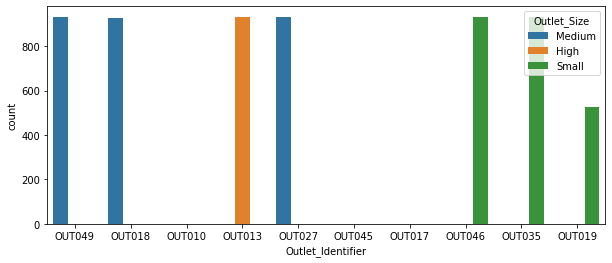

In [19]:
plt.figure(figsize=(10,4))
sns.countplot(df['Outlet_Identifier'],hue=df["Outlet_Size"])

C:\Users\kannu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Type', ylabel='count'>

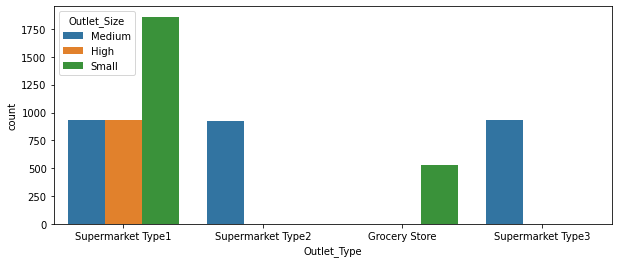

In [20]:
plt.figure(figsize=(10,4))
sns.countplot(df['Outlet_Type'],hue=df["Outlet_Size"])

C:\Users\kannu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='count'>

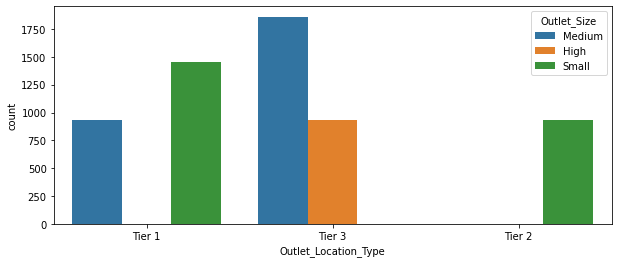

In [21]:
plt.figure(figsize=(10,4))
sns.countplot(df['Outlet_Location_Type'],hue=df["Outlet_Size"])

In [22]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8514,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8515,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8516,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8517,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


## Hence no exact realtion found , hnece will replace outlet size by mode according outlet type.

In [24]:
df.pivot_table(values='Outlet_Size',index='Outlet_Type',aggfunc=lambda x:mode(x)[0][0])

,Outlet_Size
Outlet_Type,
Grocery Store,Small
Supermarket Type1,Small
Supermarket Type2,Medium
Supermarket Type3,Medium


In [25]:
miss_bool=df["Outlet_Size"].isna()
null_outsize=df[miss_bool]

In [26]:
def fill_size(data):
    if (data == "Grocery Store") or (data=="Supermarket Type1") :
        return "Small"
    elif (data == "Supermarket Type2") or (data == "Supermarket Type3"):
        return "Medium"
    

In [27]:
size_data=null_outsize["Outlet_Type"].apply(fill_size)
index_null=size_data.index

In [28]:
#fill these values in df

def fill_data(index):
    if index in index_null:
        return size_data[index]
    else:
        return df["Outlet_Size"][index]



In [29]:
df["Outlet_Size"]=df.reset_index()['index'].apply(fill_data)

In [30]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## item identifier and outlet identifier is not of our use hence deleting them.

In [31]:

df.drop(["Item_Identifier","Outlet_Identifier"],axis=1,inplace=True)

In [32]:
df['Item_Fat_Content'].value_counts()


Low Fat    5088
Regular    2886
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

## Cleaning

In [33]:
df['Item_Fat_Content'].value_counts().to_dict()

{'Low Fat': 5088, 'Regular': 2886, 'LF': 316, 'reg': 117, 'low fat': 112}

In [34]:
df['Item_Fat_Content'].replace({'Low Fat': 'Low Fat', 'Regular': 'Regular', 'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'},inplace=True)

In [35]:
df['Item_Fat_Content'].value_counts()

Low Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64

In [36]:
df['Item_Type'].value_counts()


Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

## Making group of drink, edible, non edible

In [37]:
df['Item_Type'].replace({'Fruits and Vegetables': "edible",
 'Snack Foods': "edible",
 'Household': "non edible",
 'Frozen Foods': "edible",
 'Canned': "drink",
 'Baking Goods': "edible",
 'Health and Hygiene': "non edible",
 'Soft Drinks': "drink",
 'Meat': "edible",
 'Breads': "edible",
 'Hard Drinks': "drink",
 'Starchy Foods': "edible",
 'Breakfast':"edible",
 'Seafood': "edible"},inplace=True)

In [38]:
df['Item_Type'].value_counts()


edible        4931
non edible    1430
drink         1308
Dairy          681
Others         169
Name: Item_Type, dtype: int64

In [39]:
# converting Outlet_Establishment_Year into time duration

df["Established_period"]=2022-df["Outlet_Establishment_Year"]

In [40]:
df.drop("Outlet_Establishment_Year",axis=1,inplace=True)

In [41]:
df["Outlet_Location_Type"].value_counts()  #no need of change

Tier 3    3347
Tier 2    2785
Tier 1    2387
Name: Outlet_Location_Type, dtype: int64

In [42]:
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Established_period
Item_Weight,1.000000,-0.009173,0.025975,0.013168,0.013426
Item_Visibility,-0.009173,1.000000,-0.001155,-0.128297,0.074325
Item_MRP,0.025975,-0.001155,1.000000,0.567803,-0.004599
Item_Outlet_Sales,0.013168,-0.128297,0.567803,1.000000,0.049083
Established_period,0.013426,0.074325,-0.004599,0.049083,1.000000


In [43]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1082
Supermarket Type3     932
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [44]:
# performing one hot encoding on --Item_Type
#Ordinal encoding on --Item_Fat_Content,Outlet_Size,Outlet_Location_Type,Outlet_Type

In [45]:
df

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Established_period
0,9.300,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380,23
1,5.920,Regular,0.019278,drink,48.2692,Medium,Tier 3,Supermarket Type2,443.4228,13
2,17.500,Low Fat,0.016760,edible,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700,23
3,19.200,Regular,0.000000,edible,182.0950,Small,Tier 3,Grocery Store,732.3800,24
4,8.930,Low Fat,0.000000,non edible,53.8614,High,Tier 3,Supermarket Type1,994.7052,35
...,...,...,...,...,...,...,...,...,...,...
8514,6.865,Low Fat,0.056783,edible,214.5218,High,Tier 3,Supermarket Type1,2778.3834,35
8515,8.380,Regular,0.046982,edible,108.1570,Small,Tier 2,Supermarket Type1,549.2850,20
8516,10.600,Low Fat,0.035186,non edible,85.1224,Small,Tier 2,Supermarket Type1,1193.1136,18
8517,7.210,Regular,0.145221,edible,103.1332,Medium,Tier 3,Supermarket Type2,1845.5976,13


In [46]:
ohe=OneHotEncoder(drop='first',sparse=False,dtype='int')
oe_fat=OrdinalEncoder(categories=[["Low Fat","Regular"]],dtype='int')
oe_size=OrdinalEncoder(categories=[["Small","Medium","High"]],dtype='int')
oe_tier=OrdinalEncoder(categories=[["Tier 3","Tier 2","Tier 1"]],dtype='int')
oe_type=OrdinalEncoder(categories=[["Grocery Store","Supermarket Type1","Supermarket Type2","Supermarket Type3"]],dtype='int')

In [47]:
df,y=df.drop("Item_Outlet_Sales",axis=1),df['Item_Outlet_Sales']

In [48]:
transformer=ColumnTransformer(transformers=[("ohe",ohe,["Item_Type"]),("oe_fat",oe_fat,["Item_Fat_Content"]),("oe_size",oe_size,['Outlet_Size']),("oe_tier",oe_tier,['Outlet_Location_Type']),("oe_type",oe_type,['Outlet_Type'])],remainder='passthrough')
data=transformer.fit_transform(df)
new_df=pd.DataFrame(data,columns=transformer.get_feature_names_out())
new_df

,ohe__Item_Type_Others,ohe__Item_Type_drink,ohe__Item_Type_edible,ohe__Item_Type_non edible,oe_fat__Item_Fat_Content,oe_size__Outlet_Size,oe_tier__Outlet_Location_Type,oe_type__Outlet_Type,remainder__Item_Weight,remainder__Item_Visibility,remainder__Item_MRP,remainder__Established_period
0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,9.300,0.016047,249.8092,23.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,5.920,0.019278,48.2692,13.0
2,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,17.500,0.016760,141.6180,23.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,19.200,0.000000,182.0950,24.0
4,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,8.930,0.000000,53.8614,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8514,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,6.865,0.056783,214.5218,35.0
8515,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,8.380,0.046982,108.1570,20.0
8516,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,10.600,0.035186,85.1224,18.0
8517,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,7.210,0.145221,103.1332,13.0


In [49]:
x=new_df

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=5)

In [51]:
lin_reg=LinearRegression()
lin_reg.fit(x_train,y_train)
test=lin_reg.score(x_test,y_test)
train=lin_reg.score(x_train,y_train)
print(f"Training data score = {train}\nTesting data score = {test}")

Training data score = 0.5052256353691563
Testing data score = 0.4850400268164895


In [52]:
parm={"n_neighbors":np.arange(2,20),'p':[1,2]}

model=KNeighborsRegressor()
grid=GridSearchCV(model,parm)
grid.fit(x_train,y_train)


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                         'p': [1, 2]})

In [53]:
grid.best_params_

{'n_neighbors': 11, 'p': 1}

In [54]:
knn=grid.best_estimator_

In [55]:
knn.fit(x_train,y_train)
train=knn.score(x_train,y_train)
test=knn.score(x_test,y_test)
print(f"Training data score = {train}\nTesting data score = {test}")

Training data score = 0.618608054247389
Testing data score = 0.5185601398177928


In [56]:
hyp_parm={"criterion":["absolute_error","squared_error"],"max_depth":np.arange(4,12),"min_samples_split":np.arange(3,12),"min_samples_leaf":np.arange(3,15)}
model=DecisionTreeRegressor()
rand_cv=RandomizedSearchCV(model,hyp_parm)
rand_cv.fit(x_train,y_train)


RandomizedSearchCV(estimator=DecisionTreeRegressor(),
                   param_distributions={'criterion': ['absolute_error',
                                                      'squared_error'],
                                        'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11]),
                                        'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_split': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])})

In [57]:
rand_cv.best_params_

{'min_samples_split': 11,
 'min_samples_leaf': 5,
 'max_depth': 6,
 'criterion': 'squared_error'}

In [58]:
dt=rand_cv.best_estimator_
dt.fit(x_train,y_train)
train=dt.score(x_train,y_train)
test=dt.score(x_test,y_test)
print(f"Training data score = {train}\nTesting data score = {test}")

Training data score = 0.620729457115607
Testing data score = 0.5753926527888291


In [60]:
parm={"n_estimators":np.arange(80,120),
      "criterion":["squared_error","absolute_error"],
      "min_samples_split":np.arange(4,8),
      "min_samples_leaf":np.arange(4,8),"random_state":[5]}
model=RandomForestRegressor()
rand_rf=RandomizedSearchCV(model,parm)
rand_rf.fit(x_train,y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'min_samples_leaf': array([4, 5, 6, 7]),
                                        'min_samples_split': array([4, 5, 6, 7]),
                                        'n_estimators': array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119]),
                                        'random_state': [5]})

In [64]:
rand_rf.best_params_

{'random_state': 5,
 'n_estimators': 82,
 'min_samples_split': 5,
 'min_samples_leaf': 7,
 'criterion': 'squared_error'}

In [65]:
rf=rand_rf.best_estimator_
rf.fit(x_train,y_train)
train=rf.score(x_train,y_train)
test=rf.score(x_test,y_test)
print(f"Training data score = {train}\nTesting data score = {test}")

Training data score = 0.7500459996078996
Testing data score = 0.5633624911718554


In [66]:
with open('Random_forest_big_market.pkl',"wb") as file:
    pickle.dump(rf,file)

In [67]:
parm={'n_estimators':np.arange(50,150),'random_state':[5]}
model=AdaBoostRegressor()
random_ada=RandomizedSearchCV(model,parm)
random_ada.fit(x_train,y_train)


RandomizedSearchCV(estimator=AdaBoostRegressor(),
                   param_distributions={'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149]),
                                        'random_state': [5]})

In [68]:
random_ada.best_params_

{'random_state': 5, 'n_estimators': 50}

In [69]:
ada=random_ada.best_estimator_
ada.fit(x_train,y_train)
train=ada.score(x_train,y_train)
test=ada.score(x_test,y_test)
print(f"Training data score = {train}\nTesting data score = {test}")


Training data score = 0.5365539446396923
Testing data score = 0.4973300301093705


In [70]:
xg=XGBRegressor()
xg.fit(x_train,y_train)
train=xg.score(x_train,y_train)
test=xg.score(x_test,y_test)
print(f"Training data score = {train}\nTesting data score = {test}")

Training data score = 0.8554301418919633
Testing data score = 0.5066102480567144


In [71]:
hyp_parm={
 'max_depth':range(3,15),
 'min_child_weight':range(1,6)}
    
model=XGBRegressor()

grid=RandomizedSearchCV(model,hyp_parm)
grid.fit(x_train,y_train)
    

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'max_depth': range(3, 15),
                                        'min_child_weight': range(1, 6)})

In [72]:
grid.best_params_

{'min_child_weight': 2, 'max_depth': 5}

In [73]:
xg_tuned=grid.best_estimator_
xg_tuned.fit(x_train,y_train)
train=xg_tuned.score(x_train,y_train)
test=xg_tuned.score(x_test,y_test)
print(f"Training data score = {train}\nTesting data score = {test}")

Training data score = 0.8012190601791225
Testing data score = 0.528099090552749


In [74]:
sv=SVR()
sv.fit(x_train,y_train)
train=sv.score(x_train,y_train)
test=sv.score(x_test,y_test)
print(f"Training data score = {train}\nTesting data score = {test}")

Training data score = 0.18882703096268905
Testing data score = 0.19557766234176865


## Evalution Using test.csv file 

In [75]:
df=pd.read_csv(r'test.csv')


In [76]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [77]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [78]:
weight=df.pivot_table(values="Item_Weight",index="Item_Identifier")
weight.head()


,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [79]:
op=df.groupby("Item_Identifier").mean()
item_to_remove=list(op[op["Item_Weight"].isna()].index)
item_to_remove

['DRN47',
 'FDF04',
 'FDF05',
 'FDF22',
 'FDG09',
 'FDG50',
 'FDG57',
 'FDH58',
 'FDI45',
 'FDJ09',
 'FDL58',
 'FDO22',
 'FDP28',
 'FDT21',
 'FDY57',
 'NCJ30']

In [80]:
df=df.drop(df[df["Item_Identifier"].isin(item_to_remove)].index,axis=0).reset_index(drop=True)
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3
...,...,...,...,...,...,...,...,...,...,...,...
5656,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1
5657,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2
5658,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1
5659,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [81]:
miss_bool=df["Item_Weight"].isna()

In [82]:
df.loc[miss_bool,"Item_Weight"]

4      NaN
7      NaN
12     NaN
18     NaN
23     NaN
        ..
5635   NaN
5636   NaN
5641   NaN
5645   NaN
5649   NaN
Name: Item_Weight, Length: 956, dtype: float64

In [83]:
df.loc[miss_bool,"Item_Identifier"][df.loc[miss_bool,"Item_Identifier"]=="DRG01"]

Series([], Name: Item_Identifier, dtype: object)

In [84]:
avg_item_weight=df.loc[miss_bool,"Item_Identifier"].apply(lambda x:weight.loc[x].values[0])
index_val=avg_item_weight.index
index_val

Int64Index([   4,    7,   12,   18,   23,   30,   33,   35,   36,   39,
            ...
            5607, 5614, 5620, 5623, 5628, 5635, 5636, 5641, 5645, 5649],
           dtype='int64', length=956)

In [85]:
def fill_weight(index):
    if index in(index_val):
        return avg_item_weight[index]
    else:
        return df["Item_Weight"][index]
    
    
df["Item_Weight"]=df.reset_index()['index'].apply(fill_weight)

In [86]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [87]:
df.pivot_table(values='Outlet_Size',index='Outlet_Type',aggfunc=lambda x:mode(x)[0][0])

,Outlet_Size
Outlet_Type,
Grocery Store,Small
Supermarket Type1,Small
Supermarket Type2,Medium
Supermarket Type3,Medium


In [88]:
miss_bool=df["Outlet_Size"].isna()
null_outsize=df[miss_bool]

In [89]:
def fill_size(data):
    if (data == "Grocery Store") or (data=="Supermarket Type1") :
        return "Small"
    elif (data == "Supermarket Type2") or (data == "Supermarket Type3"):
        return "Medium"
    

In [90]:
size_data=null_outsize["Outlet_Type"].apply(fill_size)
index_null=size_data.index

In [91]:
def fill_data(index):
    if index in index_null:
        return size_data[index]
    else:
        return df["Outlet_Size"][index]

In [92]:
df["Outlet_Size"]=df.reset_index()['index'].apply(fill_data)

In [93]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [94]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [95]:
new_df=df.drop(["Item_Identifier","Outlet_Identifier"],axis=1)

In [96]:
new_df['Item_Fat_Content'].replace({'Low Fat': 'Low Fat', 'Regular': 'Regular', 'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'},inplace=True)

In [97]:
new_df

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,20.750,Low Fat,0.007565,Snack Foods,107.8622,1999,Medium,Tier 1,Supermarket Type1
1,8.300,Regular,0.038428,Dairy,87.3198,2007,Small,Tier 2,Supermarket Type1
2,14.600,Low Fat,0.099575,Others,241.7538,1998,Small,Tier 3,Grocery Store
3,7.315,Low Fat,0.015388,Snack Foods,155.0340,2007,Small,Tier 2,Supermarket Type1
4,13.600,Regular,0.118599,Dairy,234.2300,1985,Medium,Tier 3,Supermarket Type3
...,...,...,...,...,...,...,...,...,...
5656,10.500,Regular,0.013496,Snack Foods,141.3154,1997,Small,Tier 1,Supermarket Type1
5657,7.600,Regular,0.142991,Starchy Foods,169.1448,2009,Medium,Tier 3,Supermarket Type2
5658,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,2002,Small,Tier 2,Supermarket Type1
5659,15.300,Regular,0.000000,Canned,214.6218,2007,Small,Tier 2,Supermarket Type1


In [98]:
new_df['Item_Type'].replace({'Fruits and Vegetables': "edible",
 'Snack Foods': "edible",
 'Household': "non edible",
 'Frozen Foods': "edible",
 'Canned': "drink",
 'Baking Goods': "edible",
 'Health and Hygiene': "non edible",
 'Soft Drinks': "drink",
 'Meat': "edible",
 'Breads': "edible",
 'Hard Drinks': "drink",
 'Starchy Foods': "edible",
 'Breakfast':"edible",
 'Seafood': "edible"},inplace=True)

In [99]:
new_df["Established_period"]=2022-new_df["Outlet_Establishment_Year"]

In [100]:
new_df.drop("Outlet_Establishment_Year",axis=1,inplace=True)

In [101]:
new_df

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Established_period
0,20.750,Low Fat,0.007565,edible,107.8622,Medium,Tier 1,Supermarket Type1,23
1,8.300,Regular,0.038428,Dairy,87.3198,Small,Tier 2,Supermarket Type1,15
2,14.600,Low Fat,0.099575,Others,241.7538,Small,Tier 3,Grocery Store,24
3,7.315,Low Fat,0.015388,edible,155.0340,Small,Tier 2,Supermarket Type1,15
4,13.600,Regular,0.118599,Dairy,234.2300,Medium,Tier 3,Supermarket Type3,37
...,...,...,...,...,...,...,...,...,...
5656,10.500,Regular,0.013496,edible,141.3154,Small,Tier 1,Supermarket Type1,25
5657,7.600,Regular,0.142991,edible,169.1448,Medium,Tier 3,Supermarket Type2,13
5658,10.000,Low Fat,0.073529,non edible,118.7440,Small,Tier 2,Supermarket Type1,20
5659,15.300,Regular,0.000000,drink,214.6218,Small,Tier 2,Supermarket Type1,15


In [104]:
data=transformer.transform(new_df)
data

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        7.56483600e-03, 1.07862200e+02, 2.30000000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.84276770e-02, 8.73198000e+01, 1.50000000e+01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.95749080e-02, 2.41753800e+02, 2.40000000e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.35285610e-02, 1.18744000e+02, 2.00000000e+01],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.14621800e+02, 1.50000000e+01],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.04720151e-01, 7.97960000e+01, 2.00000000e+01]])

In [108]:
x=pd.DataFrame(data,columns=transformer.get_feature_names_out())
result=rf.predict(x)

In [109]:
y_train_predict=rf.predict(x_train)
mse_train=mean_squared_error(y_train,y_train_predict)
mse_train

733678.9474431134

In [110]:
y_test_predict=rf.predict(x_test)
mse_test=mean_squared_error(y_test,y_test_predict)
mse_test

1230082.5646299096

In [112]:
result_df=df[["Item_Identifier","Outlet_Identifier"]]

In [113]:
result_df["Item_Outlet_Sales"]=result

C:\Users\kannu\AppData\Local\Temp\ipykernel_19008\4181413131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["Item_Outlet_Sales"]=result


In [114]:
result_df

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1765.075860
1,FDW14,OUT017,1261.918081
2,NCN55,OUT010,587.245364
3,FDQ58,OUT017,2290.096264
4,FDY38,OUT027,6207.506480
...,...,...,...
5656,FDB58,OUT046,2408.958357
5657,FDD47,OUT018,2594.937149
5658,NCO17,OUT045,1833.305132
5659,FDJ26,OUT017,3544.639197


In [115]:
result_df.to_csv("Big_mart_solution.csv",index=False)